# ResNet Implementation practice

# Table of Contents

Implementation practice for ResNet(2015).

**1. Setup: Tools for modeling, plotting, etc.**

**2. Loading Datasets: Used CIFAR-10.** 

**3. ResNet: Implementing ResNet class, Basic building block class, and bottleneck class.**

**4. Train: Define functions for training the model.**

**5. Plot the result**

**6. Summary**


# Setup 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T

import numpy as np
import matplotlib.pyplot as plt

USE_GPU = True
dtype = torch.float32 # We will be using float throughout this tutorial.

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss.
print_every = 100
print('using device:', device)

using device: cuda


# Loading Datasets - CIFAR-10

In [2]:
NUM_TRAIN = 49000

# The torchvision.transforms package provides tools for preprocessing data
# and for performing data augmentation; here we set up a transform to
# preprocess the data by subtracting the mean RGB value and dividing by the
# standard deviation of each RGB value; we've hardcoded the mean and std.
transform = T.Compose([
                T.ToTensor(),
                T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
            ])

# We set up a Dataset object for each split (train / val / test); Datasets load
# training examples one at a time, so we wrap each Dataset in a DataLoader which
# iterates through the Dataset and forms minibatches. We divide the CIFAR-10
# training set into train and val sets by passing a Sampler object to the
# DataLoader telling how it should sample from the underlying Dataset.
cifar10_train = dset.CIFAR10('./datasets', train=True, download=True,
                             transform=transform)
loader_train = DataLoader(cifar10_train, batch_size=128, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

cifar10_val = dset.CIFAR10('./datasets', train=True, download=True,
                           transform=transform)
loader_val = DataLoader(cifar10_val, batch_size=128, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))

cifar10_test = dset.CIFAR10('./datasets', train=False, download=True, 
                            transform=transform)
loader_test = DataLoader(cifar10_test, batch_size=128)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


# ResNet


<center>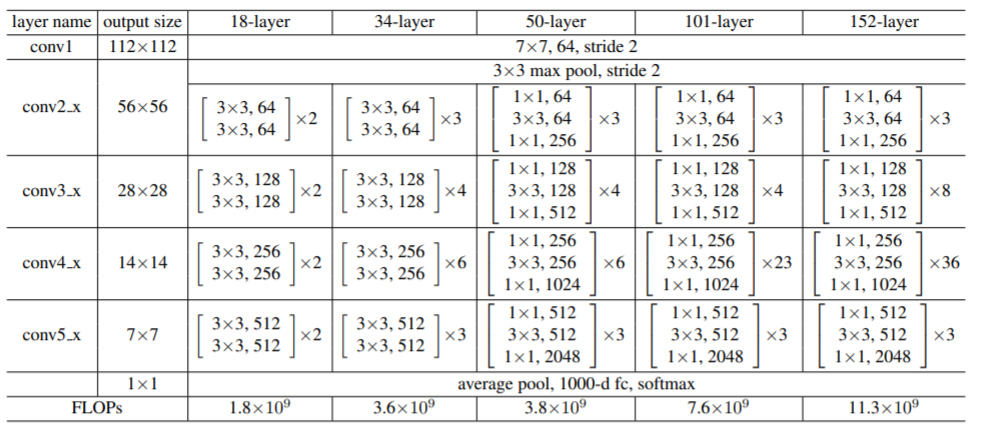<center>
<center>Summary of ResNet Architecture<center>


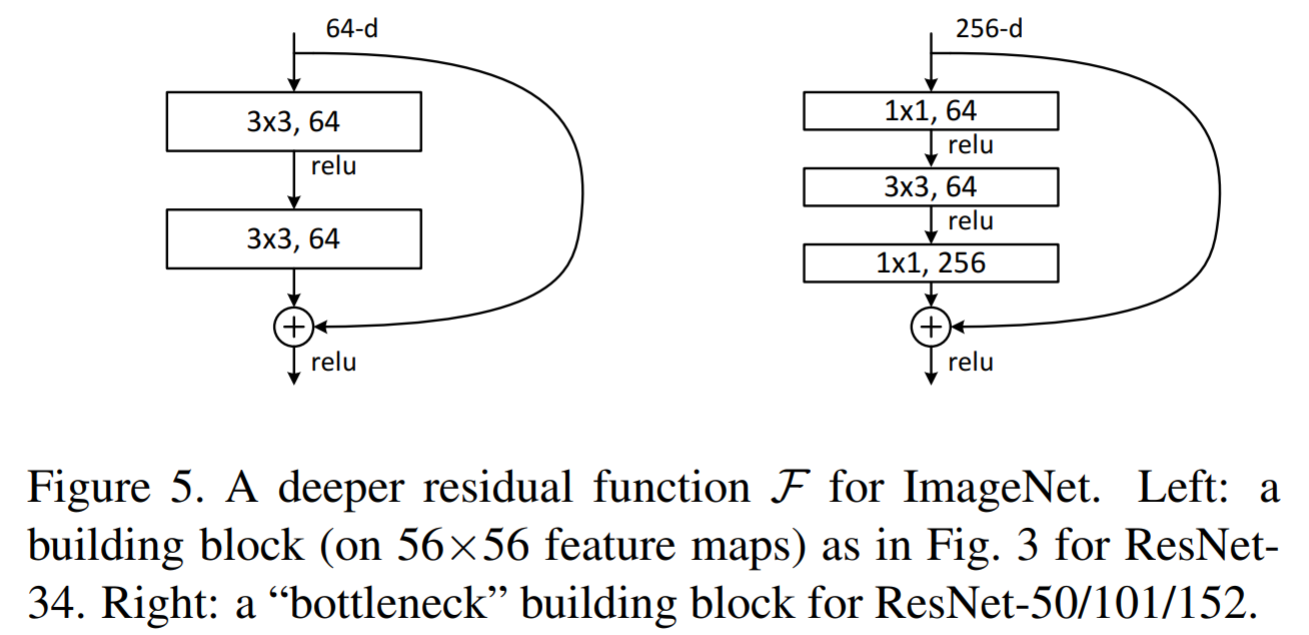

### Basic Building Block

In [3]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, strides = [1, 1], downsample = None):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = strides[0], padding = 1, bias = False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = strides[1], padding = 1, bias = False),
            nn.BatchNorm2d(out_channels)
        )
        self.relu = nn.ReLU()
        self.downsample = downsample
        
    def forward(self, x):
        out = self.block(x)
        
        # projection is identity when no dimension increase required. 
        proj = x
        if self.downsample is not None:
            proj = self.downsample(x)
        return self.relu(proj + out)

### Bottleneck Building Block

In [4]:
class Bottleneck(nn.Module):
    def __init__(self, in_channels, out_channels, strides = [1, 1], downsample = None):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size = 1, stride = strides[0], padding = 0, bias = False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = strides[1], padding = 1, bias = False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels * 4, kernel_size = 1, stride = strides[2], padding = 0, bias = False),
            nn.BatchNorm2d(out_channels * 4)
        )
        self.relu = nn.ReLU()
        self.downsample = downsample
        
    def forward(self, x):
        out = self.block(x)
        # projection is identity when no dimension increase required. 
        proj = x
        if self.downsample is not None:
            proj = self.downsample(x)
        return self.relu(proj + out)

### ResNet class

In [5]:
class ResNet(nn.Module):
    def __init__(self, net_type, num_classes = 10):
        super().__init__()
        assert net_type in [18, 34, 50, 110, 152], "Not Available ResNet type"
        
        ### The number of ResNet layers ###
        if net_type <= 34:
            self.block_type = BasicBlock
            if net_type == 18:
                blocks_list = [2, 2, 2, 2]
            else:
                blocks_list = [3, 4, 6, 3]
            self.expansion = 1
        else:
            self.block_type = Bottleneck
            if net_type == 50:
                blocks_list = [3, 4, 6, 3]
            elif net_type == 110:
                blocks_list = [3, 4, 23, 3]
            else:
                blocks_list = [3, 8, 36, 3]
            self.expansion = 4
        
        self.in_channels = 64
        
        ### Construct the architecture ###
        self.start = nn.Sequential(
            nn.Conv2d(3, self.in_channels * self.expansion, kernel_size = 7, stride = 2, padding = 3, bias = False),
            nn.BatchNorm2d(self.in_channels * self.expansion),
            nn.ReLU(),
            nn.MaxPool2d(3, stride = 2, padding = 1)
        )
        self.block1 = self.make_layer(blocks_list[0], self.block_type, 64)
        self.block2 = self.make_layer(blocks_list[1], self.block_type, 128)
        self.block3 = self.make_layer(blocks_list[2], self.block_type, 256)
        self.block4 = self.make_layer(blocks_list[3], self.block_type, 512)
        
        self.last = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(self.in_channels * self.expansion, num_classes)
        )
        
        
    def make_layer(self, blocks, block_type, out_channels):
        layers = []
        if self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels * self.expansion, out_channels * self.expansion, kernel_size = 1, stride = 2, padding = 0, bias = False),
                nn.BatchNorm2d(out_channels * self.expansion)
            )
            layers.append(self.block_type(self.in_channels * self.expansion, out_channels, strides = [2, 1, 1], downsample = downsample))
            self.in_channels = out_channels
            blocks -= 1
            
        for i in range(blocks):
            layers.append(self.block_type(self.in_channels * self.expansion, out_channels, strides = [1, 1, 1]))
            
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.start(x)
        out = self.block1(out)
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        return self.last(out)

# Train  

In [6]:
def check_accuracy(acc_list, loader, model, device):
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        acc_list.append(100 * acc)
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
        return acc_list

def train_network(model, optimizer, device, epochs = 1, warm_up = False):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    acc_list = []
    loss_list = []

    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, [100, 150], gamma=0.1)
    for e in range(epochs):
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)
            
            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                acc_list = check_accuracy(acc_list, loader_val, model, device)
                loss_list.append(loss.detach().cpu())
                print()
        if warm_up and e == 5:
            optimizer.param_groups[0]['lr'] *= 10
        scheduler.step()
    return acc_list, loss_list

In [7]:
model_18 = ResNet(18).cuda()

model_34 = ResNet(34).cuda()

model_50 = ResNet(50).cuda()

model_110 = ResNet(110).cuda()
# https://www.quora.com/Why-do-the-state-of-the-art-deep-learning-models-like-ResNet-and-DenseNet-use-SGD-with-momentum-over-Adam-for-training #
optimizer_18 = optim.SGD(model_18.parameters(), lr = 1e-1, momentum = 0.9, weight_decay=0.0001, nesterov = True)
optimizer_34 = optim.SGD(model_34.parameters(), lr = 1e-1, momentum = 0.9, weight_decay=0.0001, nesterov = True)
optimizer_50 = optim.SGD(model_50.parameters(), lr = 1e-1, momentum = 0.9, weight_decay=0.0001, nesterov = True)

########################################################################################################################################################### 
# In paper, they found that the initial learning rate of 0.1 is slightly too large to start converging for resnet110. 
# So they 0.01 to warm up the training until the training error is below 80% (about 400 iterations), and then go back to 0.1 and continue training.
# In this practice, I'll apply the same way to resnet50, too.
##########################################################################################################################################################
optimizer_110 = optim.SGD(model_110.parameters(), lr = 1e-2, momentum = 0.9, weight_decay=0.0001, nesterov = True)

epoch = 200


In [8]:
print("###############################################")
print("ResNet18")
print("###############################################")
acc_18, loss_18 = train_network(model_18, optimizer_18, device, epochs=epoch)

###############################################
ResNet18
###############################################
Iteration 0, loss = 2.5587
Checking accuracy on validation set
Got 113 / 1000 correct (11.30)

Iteration 100, loss = 2.0639
Checking accuracy on validation set
Got 303 / 1000 correct (30.30)

Iteration 200, loss = 1.6417
Checking accuracy on validation set
Got 414 / 1000 correct (41.40)

Iteration 300, loss = 1.5921
Checking accuracy on validation set
Got 475 / 1000 correct (47.50)

Iteration 0, loss = 1.3356
Checking accuracy on validation set
Got 464 / 1000 correct (46.40)

Iteration 100, loss = 1.3643
Checking accuracy on validation set
Got 517 / 1000 correct (51.70)

Iteration 200, loss = 1.2594
Checking accuracy on validation set
Got 553 / 1000 correct (55.30)

Iteration 300, loss = 1.2691
Checking accuracy on validation set
Got 562 / 1000 correct (56.20)

Iteration 0, loss = 1.1911
Checking accuracy on validation set
Got 571 / 1000 correct (57.10)

Iteration 100, loss = 1.0348

In [9]:
print("###############################################")
print("ResNet34")
print("###############################################")
acc_34, loss_34 = train_network(model_34, optimizer_34, device, epochs=epoch)

###############################################
ResNet34
###############################################
Iteration 0, loss = 2.5459
Checking accuracy on validation set
Got 107 / 1000 correct (10.70)

Iteration 100, loss = 2.0982
Checking accuracy on validation set
Got 193 / 1000 correct (19.30)

Iteration 200, loss = 1.9933
Checking accuracy on validation set
Got 241 / 1000 correct (24.10)

Iteration 300, loss = 1.7649
Checking accuracy on validation set
Got 305 / 1000 correct (30.50)

Iteration 0, loss = 1.8863
Checking accuracy on validation set
Got 343 / 1000 correct (34.30)

Iteration 100, loss = 1.8927
Checking accuracy on validation set
Got 416 / 1000 correct (41.60)

Iteration 200, loss = 1.4168
Checking accuracy on validation set
Got 438 / 1000 correct (43.80)

Iteration 300, loss = 1.6342
Checking accuracy on validation set
Got 484 / 1000 correct (48.40)

Iteration 0, loss = 1.5985
Checking accuracy on validation set
Got 466 / 1000 correct (46.60)

Iteration 100, loss = 1.3742

In [10]:
print("###############################################")
print("ResNet50")
print("###############################################")
acc_50, loss_50 = train_network(model_50, optimizer_50, device, epochs=epoch)

###############################################
ResNet50
###############################################
Iteration 0, loss = 2.7739
Checking accuracy on validation set
Got 107 / 1000 correct (10.70)

Iteration 100, loss = 5.3965
Checking accuracy on validation set
Got 110 / 1000 correct (11.00)

Iteration 200, loss = 2.0831
Checking accuracy on validation set
Got 186 / 1000 correct (18.60)

Iteration 300, loss = 2.3255
Checking accuracy on validation set
Got 261 / 1000 correct (26.10)

Iteration 0, loss = 1.7810
Checking accuracy on validation set
Got 252 / 1000 correct (25.20)

Iteration 100, loss = 1.9380
Checking accuracy on validation set
Got 281 / 1000 correct (28.10)

Iteration 200, loss = 1.7936
Checking accuracy on validation set
Got 306 / 1000 correct (30.60)

Iteration 300, loss = 1.8066
Checking accuracy on validation set
Got 360 / 1000 correct (36.00)

Iteration 0, loss = 1.8984
Checking accuracy on validation set
Got 372 / 1000 correct (37.20)

Iteration 100, loss = 1.5052

In [11]:
print("###############################################")
print("ResNet110")
print("###############################################")
acc_110, loss_110 = train_network(model_110, optimizer_110, device, epochs=epoch, warm_up = True)

###############################################
ResNet110
###############################################
Iteration 0, loss = 2.5752
Checking accuracy on validation set
Got 107 / 1000 correct (10.70)

Iteration 100, loss = 2.7187
Checking accuracy on validation set
Got 165 / 1000 correct (16.50)

Iteration 200, loss = 2.3768
Checking accuracy on validation set
Got 236 / 1000 correct (23.60)

Iteration 300, loss = 2.2589
Checking accuracy on validation set
Got 279 / 1000 correct (27.90)

Iteration 0, loss = 1.8250
Checking accuracy on validation set
Got 387 / 1000 correct (38.70)

Iteration 100, loss = 3.1309
Checking accuracy on validation set
Got 366 / 1000 correct (36.60)

Iteration 200, loss = 2.9533
Checking accuracy on validation set
Got 354 / 1000 correct (35.40)

Iteration 300, loss = 2.2383
Checking accuracy on validation set
Got 394 / 1000 correct (39.40)

Iteration 0, loss = 2.5980
Checking accuracy on validation set
Got 364 / 1000 correct (36.40)

Iteration 100, loss = 1.849

## Test set -- run this only once

Now that we've gotten a result we're happy with, we test our final model on the test set (which you should store in best_model).

In [12]:
best_model_18 = model_18
print("### ResNet 18 ###")
check_accuracy([], loader_test, best_model_18, device)

best_model_34 = model_34
print("### ResNet 34 ###")
check_accuracy([], loader_test, best_model_34, device)

best_model_50 = model_50
print("### ResNet 50 ###")
check_accuracy([], loader_test, best_model_50, device)

best_model_110 = model_110
print("### ResNet 110 ###")
check_accuracy([], loader_test, best_model_110, device)

### ResNet 18 ###
Checking accuracy on test set
Got 7775 / 10000 correct (77.75)
### ResNet 34 ###
Checking accuracy on test set
Got 7643 / 10000 correct (76.43)
### ResNet 50 ###
Checking accuracy on test set
Got 7739 / 10000 correct (77.39)
### ResNet 110 ###
Checking accuracy on test set
Got 7739 / 10000 correct (77.39)


[77.39]

# Plot the result

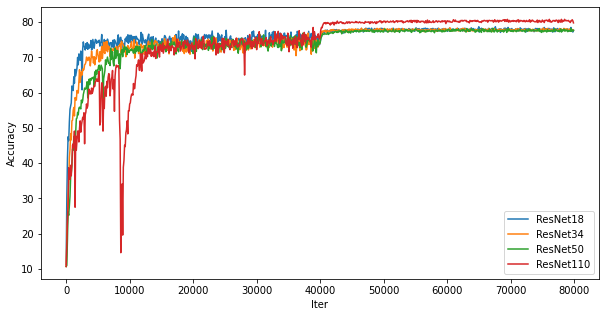

In [13]:
iteration = range(0, 400 * epoch, 100)
plt.figure(figsize=(10,5)) 
plt.xlabel('Iter')
plt.ylabel('Accuracy')
plt.plot(iteration, acc_18, label = "ResNet18")
plt.plot(iteration, acc_34, label = "ResNet34")
plt.plot(iteration, acc_50, label = "ResNet50")
plt.plot(iteration, acc_110, label = "ResNet110")
plt.legend()
plt.show()

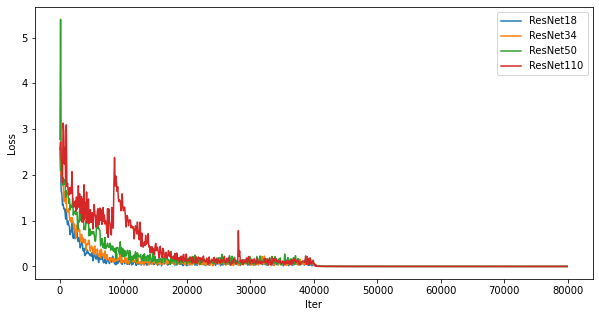

In [14]:
plt.figure(figsize=(10,5)) 
plt.xlabel('Iter')
plt.ylabel('Loss')
plt.plot(iteration, loss_18, label = "ResNet18")
plt.plot(iteration, loss_34, label = "ResNet34")
plt.plot(iteration, loss_50, label = "ResNet50")
plt.plot(iteration, loss_110, label = "ResNet110")
plt.legend()
plt.show()

# Summary 
The accuracies of models were high in the order of **ResNet101, (50, 34, 18)**. (I cannot rank 18, 34 and 50 well.)


But, the result indicates that the degradation problem is in order. 


The reason why ResNet110 cannot reach the higher accuracy than 80% may be **overfitting** as the author mentioned in the paper. I guess ResNet110 is too large for this small dataset.


I also guess if the data augmentation is added at the beginning of the process, the gaps between each models will appear more noticeably.